Setup Packages and Functions
===

In [118]:
from pystan import StanModel
# import stanity
n_jobs = 4
import pandas as pd
import seaborn as sns
sns.set_color_codes()
%pylab inline
from scipy.stats import norm, truncnorm, multivariate_normal, lognorm, gaussian_kde

Populating the interactive namespace from numpy and matplotlib


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['multivariate_normal', 'cov', 'norm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [98]:
from pystan.misc import _summary, _array_to_table
def _print_stanfit(fit, pars=None, probs=(0.025, 0.25, 0.5, 0.75, 0.975), digits_summary=2):
        if fit.mode == 1:
            return "Stan model '{}' is of mode 'test_grad';\n"\
                   "sampling is not conducted.".format(fit.model_name)
        elif fit.mode == 2:
            return "Stan model '{}' does not contain samples.".format(fit.model_name)
        if pars is None:
            pars = fit.sim['pars_oi']
            fnames = fit.sim['fnames_oi']

        n_kept = [s - w for s, w in zip(fit.sim['n_save'], fit.sim['warmup2'])]
        header = ""#Inference for Stan model: {}.\n".format(fit.model_name)
        header += "{} chains, each with iter={}; warmup={}; thin={}; \n"
        header = header.format(fit.sim['chains'], fit.sim['iter'], fit.sim['warmup'],
                               fit.sim['thin'], sum(n_kept))
        header += "post-warmup draws per chain={}, total post-warmup draws={}.\n\n"
        header = header.format(n_kept[0], sum(n_kept))
        footer = "\n\nSamples were drawn using {} at {}.\n"\
#             "For each parameter, n_eff is a crude measure of effective sample size,\n"\
#             "and Rhat is the potential scale reduction factor on split chains (at \n"\
#             "convergence, Rhat=1)."
        sampler = fit.sim['samples'][0]['args']['sampler_t']
        date = fit.date.strftime('%c')  # %c is locale's representation
        footer = footer.format(sampler, date)
        s = _summary(fit, pars, probs)
        body = _array_to_table(s['summary'], s['summary_rownames'],
                               s['summary_colnames'], digits_summary)
        return header + body + footer
    
def plot_time_series_inference(model_fit, var='Y_sim', x=None,
                               ax=None, ind=0, **kwargs):
    from scipy.stats import scoreatpercentile
    ci_thresholds = [2.5, 25, 75, 97.5]
    if len(model_fit[var].shape)<3:
        data = model_fit[var]
    else:
        data = model_fit[var][:,:,ind]
    CIs = scoreatpercentile(data, ci_thresholds, axis=0)
    CIs = pd.DataFrame(data=CIs.T, columns=ci_thresholds)
    if ax is None:
        ax=gca()
    if x is None:
        x = arange(data.shape[1])
    ax.fill_between(x, CIs[2.5], CIs[97.5],alpha=.5, **kwargs)
    ax.fill_between(x, CIs[25], CIs[75], **kwargs)
    
from scipy.stats import percentileofscore
def portion_of_data_within_CI(model_fit, parameter, data, lower=2.5, upper=97.5):
    if data.ndim<2:
        a = array((list(map(percentileofscore, model_fit[parameter].T, data))))
        return mean((lower<a)*(a<upper))
    else:
        values = empty(data.shape[1])
        for i in range(data.shape[1]):
            a = array((list(map(percentileofscore, model_fit[parameter][:,i], data.iloc[:,i]))))
            values[i]=nanmean((lower<a)*(a<upper))
        return values
    
def portion_of_forecast_within_CI(model_fit, forecast, data, 
                                  forecast_start_ind, forecast_stop_ind,
                                  lower=2.5, upper=97.5):
    u = percentile(model_fit[forecast],upper,axis=0)
    l = percentile(model_fit[forecast],lower,axis=0)
    return nanmean((l[forecast_start_ind:forecast_stop_ind]<data[forecast_start_ind:forecast_stop_ind])*
                   (data[forecast_start_ind:forecast_stop_ind]<u[forecast_start_ind:forecast_stop_ind]),
                  axis=0)

def calculate_Omega_from_L_Omega(model_fit):
    f = lambda x,y: matrix(x)*matrix(y)
    return list(map(f, model_fit['L_Omega'], transpose(model_fit['L_Omega'],[0,2,1])))

def calculate_covariance_from_L_Omega_and_tau(model_fit):
    Omegas = calculate_Omega_from_L_Omega(model_fit)
    f = lambda tau, Omega: diag(tau)*Omega*diag(tau)
    return list(map(f, model_fit['tau'], Omegas))

Load Empirical Data and Look at It
===

In [99]:
data_directory = '../data/'

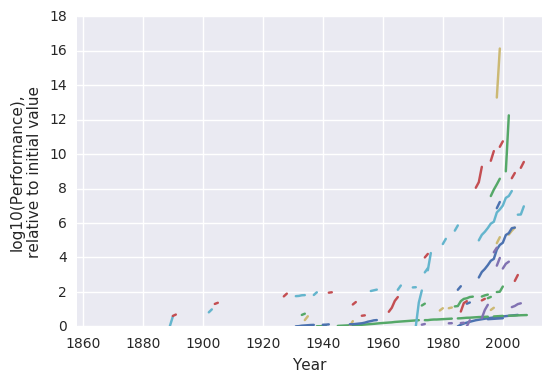

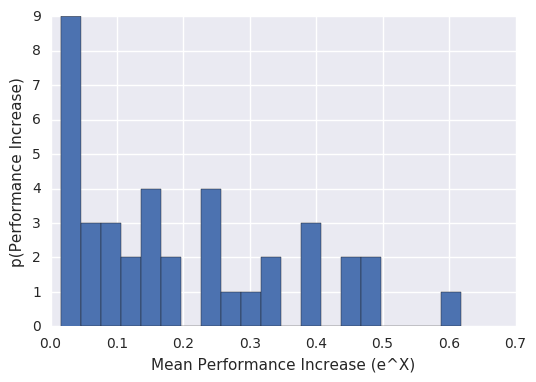

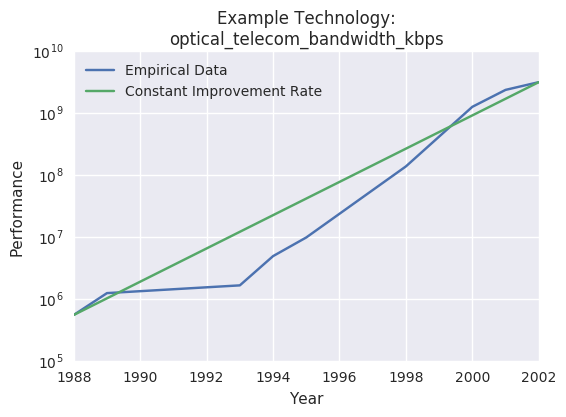

In [100]:
empirical_data = pd.read_csv(data_directory+'time_series.csv',index_col=0)
empirical_data = empirical_data.reindex(arange(empirical_data.index[0],empirical_data.index[-1]+1))
metadata = pd.read_csv(data_directory+'time_series_metadata.csv')

target_tech_names = metadata.ix[metadata['Type']=='Performance', 'Name']

figure()
q = empirical_data[target_tech_names]
r = q
r = r/r.apply(lambda x: x.ix[pd.Series.first_valid_index(x)])
r = log10(r)
r.plot(legend=False,kind='line')
xlabel("Year")
ylabel("log10(Performance),\nrelative to initial value")

figure()
z = log(q).apply(lambda x: (x.ix[x.last_valid_index()]-x.ix[x.first_valid_index()])/(x.last_valid_index()-x.first_valid_index()))
z.hist(bins=20)
xlabel("Mean Performance Increase (e^X)")
ylabel("p(Performance Increase)")

figure()
title("Example Technology:\n%s"%z.argmax())
n = (q)[z.argmax()].dropna()
n.plot(label='Empirical Data')
y = [n.iloc[0]]
for i in arange(n.index[0], n.index[-1]):
    y.append(y[-1]*exp(z.max()))
plot(arange(n.index[0], n.index[-1]+1), y, label='Constant Improvement Rate')
yscale('log')
legend(loc='upper left')
xlabel("Year")
ylabel("Performance")

Load Stan programs
====

In [168]:
import pickle
models = pickle.load(open('model.pkl', 'rb'))

Define a Python helper function that will take time series data and generate the variables to pass to the Stan program.
----

In [141]:
def stan_data_from_Y(Y,
                     backcast_to_observation=1,
                    forecast_to_observation=None):
    Y = Y.copy()
    Y.index = arange(Y.shape[0])
    Y.columns = arange(Y.shape[1])
    N_time_periods, N_technologies = Y.shape
    first_observation = Y.apply(lambda x: x.first_valid_index())
    last_observation = Y.apply(lambda x: x.last_valid_index())
    first_observation_value = Y.apply(lambda x: x[x.first_valid_index()])

    if forecast_to_observation is None:
        forecast_to_observation = Y.shape[0]+1
        
    N_updates = sum(last_observation-first_observation)
    
    updates_vector = []
    tech_starts = []
    tech_stops = []
    updates_tech_inds = []
    for i in Y.columns:
        tech_starts.append(len(updates_vector))
        this_updates = Y.ix[first_observation[i]:last_observation[i],i].diff()[1:].values.tolist()
        updates_vector += this_updates
        tech_stops.append(len(updates_vector))
        updates_tech_inds+=[i for j in this_updates]
    updates_vector = pd.Series(updates_vector)
    N_updates = len(updates_vector)

    N_gap_updates = {}
    gap_starts = {}
    gap_stops = {}
    gap_lengths = {}
    gap_heights = {}
    gap_time_steps = {}
    gap_techs = {}
    for i in Y.columns:
        gap_inds = Y.ix[first_observation[i]:last_observation[i],i].isnull().astype('int')
        d = gap_inds.diff()
        gap_starts[i] = d[d==1].index.values.astype('int')
        gap_stops[i] = d[d==-1].index.values.astype('int')
        gap_lengths[i] = gap_stops[i]-gap_starts[i]
        N_gap_updates[i] = gap_lengths[i]+1
        gap_heights[i] = Y.ix[gap_stops[i],i].values - Y.ix[gap_starts[i]-1,i].values
        gap_time_steps[i] = gap_inds[gap_inds==1].index.values

    gap_heights_vector = []
    gap_lengths_vector = []
    for i in Y.columns:
        gap_heights_vector+=gap_heights[i].tolist()
        gap_lengths_vector+=gap_lengths[i].tolist()

    stan_data = {'N_technologies': N_technologies,
                 'N_updates': N_updates,
                 'observed_updates': updates_vector.fillna(-999.0),
                 'updates_tech_inds': array(updates_tech_inds).astype('int')+1,
                 'tech_starts': array(tech_starts).astype('int')+1,
                 'tech_stops': array(tech_stops).astype('int'),
                 'N_gaps': len(gap_heights_vector),
                 'gap_heights': gap_heights_vector,
                 'gap_lengths': array(gap_lengths_vector).astype('int'),
                 'N_gap_updates': sum([sum(N_gap_updates[i]) for i in N_gap_updates]),
                'first_observation_value': first_observation_value,                 
                'first_observation': first_observation.astype('int')+1,
                'last_observation': last_observation.astype('int')+1,
                'backcast_to_observation': backcast_to_observation,
                'forecast_to_observation': forecast_to_observation}
    
    return stan_data

Box-Cox Transform
----

In [153]:
model_name = 'improvement~BCN(mu,sigma), hierarchical'
models[model_name] = {}
models[model_name]['code']  = base_time_series_program%{

### model
'model': """
    tau ~ cauchy(0, 2);
    L_Omega ~ lkj_corr_cholesky(1);
    mu_mu ~ normal(mu_prior_location, mu_prior_scale);
    mu_sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
    lambda ~ beta(lambda_prior_shape_1, lambda_prior_shape_2);

    {
    matrix[N_technologies, 2] parvec;
    vector[2] mu_parvec;
    //vector[N_technologies] transformed_lambda;
    
    //for (tech in 1:N_technologies){
    //    transformed_lambda[tech] = (1+exp(lambda[tech]))^-1.0;
    //}
    parvec = append_col(mu, log(sigma));//, transformed_lambda));
    mu_parvec[1] = mu_mu;
    mu_parvec[2] = log(mu_sigma);
    //mu_parvec[3] = log(1/mu_lambda-1); 
    for (tech in 1:N_technologies){
        parvec[tech] ~ multi_normal_cholesky(mu_parvec, diag_pre_multiply(tau, L_Omega));
    }
    }
    {vector[N_updates] BCT_updates;
    for (tech in 1:N_technologies){
        for (t in tech_starts[tech]:tech_stops[tech]){
            if (lambda[tech]==0){
                BCT_updates[t] = log(updates[t]);
            }
            else{
                BCT_updates[t] = (updates[t]^lambda[tech]-1)/lambda[tech];
            }
        }
    }
    
    BCT_updates ~ normal(mu[updates_tech_inds], sigma[updates_tech_inds]);
    //target += lower_truncated_normal_lpdf_vector(BCT_updates, mu[updates_tech_inds], sigma[updates_tech_inds]);
    //target += lambda[updates_tech_inds] - 1 + log(BCT_updates);
    }
    
""",
    
### parameters
'parameters': """
    vector[N_technologies] mu;
    vector<lower = 0>[N_technologies] sigma;
    vector<lower = 0, upper = 1>[N_technologies] lambda;

    cholesky_factor_corr[2] L_Omega;
    vector<lower = 0>[2] tau;

    real mu_mu;
    real<lower = 0> mu_sigma;
    //real<lower = 0, upper = 1> mu_lambda;    
""",
    
#### priors
'priors':"""
    real mu_prior_location;
    real mu_prior_scale;

    real sigma_prior_location;
    real sigma_prior_scale;
    
    real lambda_prior_shape_1;
    real lambda_prior_shape_2;
""",

### increase size
'update_size': """
    if (lambda[tech]==0){
        update_size = exp(normal_rng(mu[tech],sigma[tech]));
    }
    else{
        update_size = -1.0;
        while (update_size<0){
            update_size = (normal_rng(mu[tech],sigma[tech])*lambda[tech]+1)^(1/lambda[tech]);
        }
    }
""",

### functions
'functions':"""
    real lower_truncated_normal_lpdf_vector(vector x, vector mu, vector sigma, real A) {
            return(normal_lpdf(x | mu, sigma) - normal_lccdf(A | mu, sigma));
            }
""",
### update bounds (either 0 or 1. Dictates if updates can only be positive, only negative, or both)
'update_bounds':"""<lower = 0>""",
'update_raw_bounds':"""<lower = 0, upper = 1>""",
    
}

models[model_name]['model_parameters'] = ['mu', 'sigma', 'lambda']
models[model_name]['parameter_priors'] = {
    'mu_prior_location': 0,
    'mu_prior_scale': 1,
    'sigma_prior_location': 0,
    'sigma_prior_scale': 2,
    'lambda_prior_shape_1': 1,
    'lambda_prior_shape_2': 1,    
    }

models[model_name]['stan_model'] = StanModel(model_code=models[model_name]['code'])

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cd405431fd7c6348afce188beabf6ee3 NOW.


In [122]:
### Random walk, missing data, positive steps, multiple technologies, mu and sigma are correlated across technologies
mu_mu = 10
mu_sigma = 2

Omega = matrix([[1,.7],
               [.7,1]])
tau = array([1,1])
cov = diag(tau)*Omega*diag(tau)

p_missing = 0
n = 1000
N_technologies = 2

mus = zeros(N_technologies)
sigmas = zeros(N_technologies)
lambdas = zeros(N_technologies)

simulated_data = empty((n, N_technologies))
simulated_time_series = empty((n, N_technologies))
for i in arange(N_technologies):
    while mus[i]==0:
        mu, sigma = multivariate_normal(array([mu_mu, mu_sigma]), cov=cov).rvs(1)
        if sigma>0:
            mus[i] = mu
            sigmas[i] = sigma
    lambdas[i] = 0#rand()
#     a = -mu/sigma
#     x = truncnorm(a, 1000,loc=mu, scale=sigma).rvs(n)
#     x = norm(mu,sigma).rvs(n)
#     simulated_data[:,i] = exp(x) if lambdas[i]==0 else (x*lambdas[i]+1)**(1/lambdas[i])
    simulated_data[:,i] = lognorm(sigma, scale=exp(mu), loc=0).rvs(n)

    simulated_time_series[:,i] = cumsum(simulated_data[:,i])
    missing = rand(n)<p_missing
    simulated_time_series[missing,i]=nan
    
stan_data = stan_data_from_Y(pd.DataFrame(simulated_time_series),forecast_to_observation=n+1)

In [111]:
# x = truncnorm(loc=mu, scale=sigma)
# data = (x*lambda+1)**(1/lambda)

Portion of true mus within 95% credible interval: 1.00
Portion of true sigmas within 95% credible interval: 1.00
Portion of true lambdas within 95% credible interval: 0.00
Inferred Omega:
[[ 1.          0.23898246]
 [ 0.23898246  1.        ]]
Inferred Tau:
[ 1.24956699  1.04365352]
Inferred Covariance
[[ 2.95554295  0.24201029]
 [ 0.24201029  2.33803033]]
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]        9.3  1.6e-3   0.06   9.18   9.26    9.3   9.35   9.43   1633    1.0
mu[1]       8.71  9.1e-4   0.04   8.63   8.69   8.71   8.74    8.8   2065    1.0
sigma[0]    2.02  9.3e-4   0.04   1.93   1.99   2.01   2.05   2.11   2301    1.0
sigma[1]    1.29  5.5e-4   0.03   1.23   1.27   1.29   1.31   1.35   2760    1.0
lambda[0] 1.1e-4  1.7e-6 1.0e-4 3.7e-6 3.2e-5 7.7e-5 1.5e-4 3.9e-4   3448    nan
lambda[1] 1.2e-4  2.1e-6 1.1e-4 3.7e-6

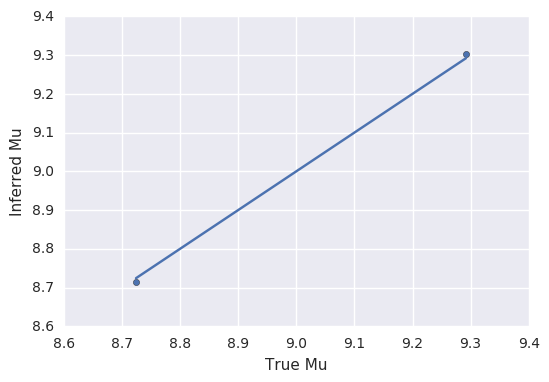

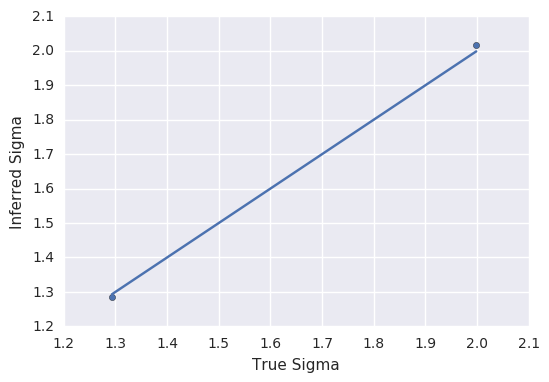

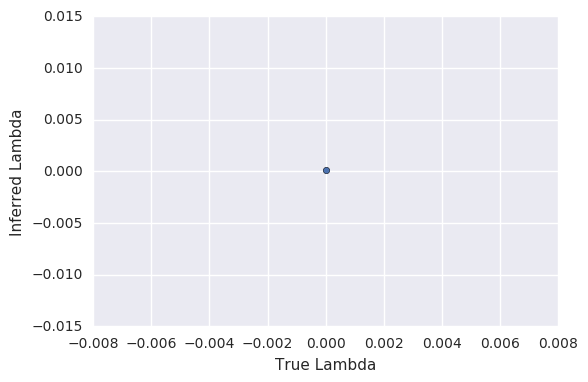

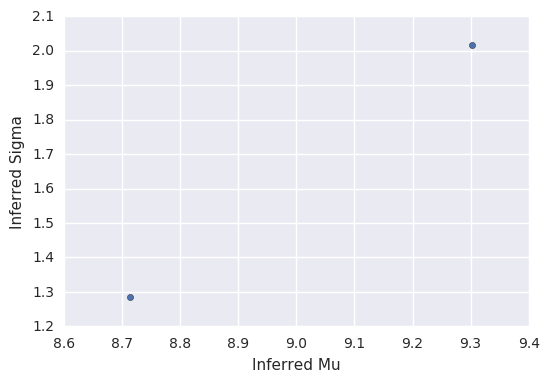

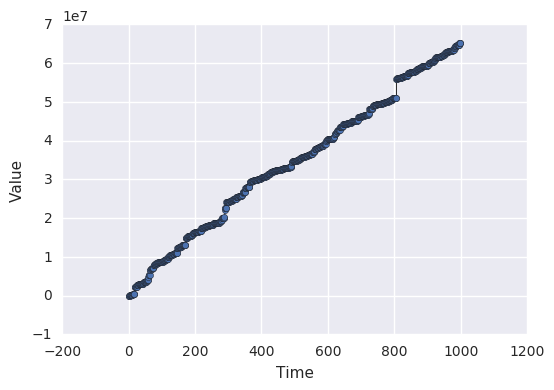

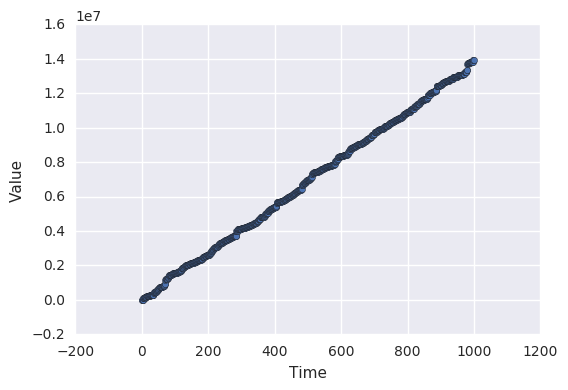

In [123]:
model_name = 'improvement~BCN(mu,sigma), hierarchical'
model_fit = models[model_name]['stan_model'].sampling(
                        data={**stan_data, 
#                               **models[model_name]['parameter_priors']},
                              **{
                                'mu_prior_location': 10,
                                'mu_prior_scale': 1,
                                'sigma_prior_location': 2,
                                'sigma_prior_scale': 2,
                                'lambda_prior_shape_1': 1,
                                'lambda_prior_shape_2': 1,    
                                }},
                        n_jobs=n_jobs)

print("Portion of true mus within 95%% credible interval: %.2f"%portion_of_data_within_CI(model_fit, 'mu', mus, 2.5, 97.5))
print("Portion of true sigmas within 95%% credible interval: %.2f"%portion_of_data_within_CI(model_fit, 'sigma', sigmas, 2.5, 97.5))
print("Portion of true lambdas within 95%% credible interval: %.2f"%portion_of_data_within_CI(model_fit, 'lambda', lambdas, 2.5, 97.5))


print("Inferred Omega:")
print(mean(calculate_Omega_from_L_Omega(model_fit),axis=0))

print("Inferred Tau:")
print(model_fit['tau'].mean(axis=0))


print("Inferred Covariance")
print(mean(calculate_covariance_from_L_Omega_and_tau(model_fit),axis=0))

print(_print_stanfit(model_fit, ['mu', 'sigma', 'lambda']))


scatter(mus,
        model_fit['mu'].mean(axis=0)
       )
plot(sort(mus),sort(mus))
xlabel("True Mu")
ylabel("Inferred Mu")

figure()
scatter(sigmas,
        model_fit['sigma'].mean(axis=0)
       )
plot(sort(sigmas),sort(sigmas))
xlabel("True Sigma")
ylabel("Inferred Sigma")

figure()
scatter(lambdas,
        model_fit['lambda'].mean(axis=0)
       )
plot(sort(lambdas),sort(lambdas))
xlabel("True Lambda")
ylabel("Inferred Lambda")

figure()
scatter(model_fit['mu'].mean(axis=0),
        model_fit['sigma'].mean(axis=0)
       )
xlabel("Inferred Mu")
ylabel("Inferred Sigma")

    
for i in arange(stan_data['N_technologies'])[:5]:
    figure()
    plot_time_series_inference(model_fit,'Y_sim',ind=i)
    scatter(arange(simulated_time_series.shape[0]),
               simulated_time_series[:,i])
    xlabel("Time")
    ylabel("Value")

Use Models to Fit Technology Performance Increases
===

In [124]:
target_tech_names = metadata.ix[metadata['Type']=='Performance', 'Name']
print("%i technologies"%target_tech_names.shape[0])

empirical_time_series = log(empirical_data[target_tech_names])

39 technologies


In [125]:
technology_models_fit_parameters = {}

In [137]:
def fit_with_model(model_name,
                   model_code=None, 
                   model_parameters=None,
                   parameter_priors=None, 
                   time_series=empirical_time_series,
                   technology_models_fit_parameters=technology_models_fit_parameters,
                   print_output=True):
    
    if model_code is None:
        model_code = models[model_name]['code']
    if model_parameters is None:
        model_parameters = models[model_name]['model_parameters']
    if parameter_priors is None:
        parameter_priors = models[model_name]['parameter_priors']
    
    technology_models_fit_parameters[model_name] = pd.DataFrame(index=model_parameters, 
                                                                columns=target_tech_names
                                                                )

    stan_data = stan_data_from_Y(time_series)
    stan_data = {**stan_data, **parameter_priors} 

    ###
    model_fit = models[model_name]['stan_model'].sampling(data=stan_data, n_jobs=n_jobs)

    if print_output:
        print(_print_stanfit(model_fit, model_parameters))
    for parameter in model_parameters:
        technology_models_fit_parameters[model_name].ix[parameter] = model_fit[parameter].mean(axis=0)

In [163]:
for model_name in ['improvement~logN(mu,sigma), hierarchical',
                   'improvement~N(mu,sigma), hierarchical']:
    if 'price' in model_name:
        continue
    print(model_name)
    fit_with_model(model_name)

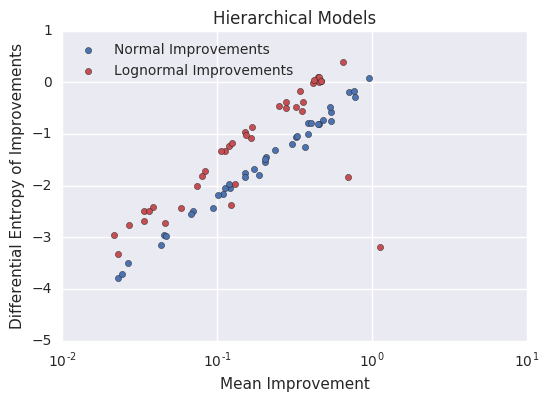

In [139]:
# dist_mean = lambda df: truncnorm(0, 10000, loc=df['mu'], scale=df['sigma']).mean()
# dist_entropy = lambda df: truncnorm(0, 10000, loc=df['mu'], scale=df['sigma']).entropy()
# x = technology_models_fit_parameters['improvement~N(mu,sigma)'].apply(dist_mean)
# y = technology_models_fit_parameters['improvement~N(mu,sigma)'].apply(dist_entropy)
# scatter(x,y, label='Normal Improvements')

# dist_mean = lambda df: lognorm(df['sigma'], scale=exp(df['mu']), loc=0).mean()
# dist_entropy = lambda df: lognorm(df['sigma'], scale=exp(df['mu']), loc=0).entropy()
# x = technology_models_fit_parameters['improvement~logN(mu,sigma)'].apply(dist_mean)
# y = technology_models_fit_parameters['improvement~logN(mu,sigma)'].apply(dist_entropy)
# scatter(x,y, label='Lognormal Improvements', c='r')

# legend(loc='upper left')
# xscale('log')
# xlabel("Mean Improvement")
# ylabel("Differential Entropy of Improvements")
# title("Non-Hierarchical Models")

figure()
dist_mean = lambda df: truncnorm(0, 10000, loc=df['mu'], scale=df['sigma']).mean()
dist_entropy = lambda df: truncnorm(0, 10000, loc=df['mu'], scale=df['sigma']).entropy()
x = technology_models_fit_parameters['improvement~N(mu,sigma), hierarchical'].apply(dist_mean)
y = technology_models_fit_parameters['improvement~N(mu,sigma), hierarchical'].apply(dist_entropy)
scatter(x,y, label='Normal Improvements')

dist_mean = lambda df: lognorm(df['sigma'], scale=exp(df['mu']), loc=0).mean()
dist_entropy = lambda df: lognorm(df['sigma'], scale=exp(df['mu']), loc=0).entropy()
x = technology_models_fit_parameters['improvement~logN(mu,sigma), hierarchical'].apply(dist_mean)
y = technology_models_fit_parameters['improvement~logN(mu,sigma), hierarchical'].apply(dist_entropy)
scatter(x,y, label='Lognormal Improvements', c='r')

legend(loc='upper left')
xscale('log')
xlabel("Mean Improvement")
ylabel("Differential Entropy of Improvements")
title('Hierarchical Models')

Use Models to Predict Future Performance
===

In [158]:
def predict_with_model(model_name, 
                       time_series,
                       training_years,
                       horizons,
                       time_series_from_each_time_period,
                       technology_forecast_models_log_pd,
                       technology_forecast_models_parameters,
                       technology_forecast_models_95CI,
                       target_tech_names,
                       model_code=None, 
                       model_parameters=None,
                       parameter_priors=None,
                       print_output=True):
    
    if model_code is None:
        model_code = models[model_name]['code']
    if model_parameters is None:
        model_parameters = models[model_name]['model_parameters']
    if parameter_priors is None:
        parameter_priors = models[model_name]['parameter_priors']
    
    technology_forecast_models_log_pd[model_name] = pd.Panel(items=target_tech_names,
         major_axis=horizons, 
         minor_axis=training_years)
    technology_forecast_models_95CI[model_name] = pd.Panel(items=target_tech_names,
         major_axis=horizons, 
         minor_axis=training_years)
    
    technology_forecast_models_parameters[model_name] = pd.Panel(items=target_tech_names,
             major_axis=model_parameters, 
             minor_axis=training_years)

    technology_forecast_models_Y_sim[model_name] = {}
    for training_year in training_years:
        print(training_year)

        forecast_start_ind = int(training_year-first_year)
        time_series_from_time_period = time_series_from_each_time_period[training_year]
        n_time_series_from_time_period = len(time_series_from_time_period)

        stan_data = stan_data_from_Y(time_series.ix[:training_year, 
                                                    time_series_from_time_period],
                                    forecast_to_observation=time_series.shape[0])
        stan_data = {**stan_data, **parameter_priors} 

        ###
        model_fit = models[model_name]['stan_model'].sampling(data=stan_data, n_jobs=n_jobs)
        Y_sim = model_fit['Y_sim']
        technology_forecast_models_Y_sim[model_name][training_year] = Y_sim
        
        if print_output:
            print(_print_stanfit(model_fit, model_parameters))
        for parameter in model_parameters:
            technology_forecast_models_parameters[model_name].ix[time_series_from_time_period, 
                                                        parameter,
                                                        training_year] = model_fit[parameter].mean(axis=0)

        for horizon in horizons:
            if horizon=='all':
                forecast_stop_ind = time_series.shape[0]
            else:
                forecast_stop_ind = horizon+forecast_start_ind
            
            times, techs = where(time_series[time_series_from_time_period].notnull())
            techs_to_forecast = techs[(forecast_start_ind<times)*(times<forecast_stop_ind)]
            times_to_forecast = times[(forecast_start_ind<times)*(times<forecast_stop_ind)]
            lpd = list(map(lambda x,y: x.logpdf(y)[0], 
                           map(gaussian_kde, Y_sim[:,times_to_forecast,techs_to_forecast].T), 
                           time_series[time_series_from_time_period].values[times_to_forecast, techs_to_forecast]))

            lpd = array(lpd)
            lpd[lpd==-inf] = log(finfo('d').tiny)
            lpd = pd.groupby(pd.Series(lpd),techs_to_forecast).sum()
            lpd = lpd.reindex(arange(len(time_series_from_time_period)))
            lpd.index = time_series_from_time_period
            technology_forecast_models_log_pd[model_name].ix[time_series_from_time_period,
                                                                 horizon,training_year] = lpd
            CI95 = portion_of_forecast_within_CI(model_fit, 'Y_sim', 
                                                 time_series[time_series_from_time_period].values, 
                                                 forecast_start_ind, 
                                                 forecast_stop_ind)
            technology_forecast_models_95CI[model_name].ix[time_series_from_time_period,
                                                           horizon,training_year] = CI95

In [161]:
training_years = arange(1950,2010,10)
horizons = [5,10,'all']

target_tech_names = metadata.ix[metadata['Type']=='Performance', 'Name']
print("%i technologies"%target_tech_names.shape[0])

empirical_time_series = log(empirical_data[target_tech_names])
min_data_points_to_include_time_series = 3

first_year = empirical_data.index[0]
performance_time_series_from_each_time_period = {}

for training_year in training_years:
    print(training_year)

    start_ind = int(training_year-first_year)
    ### Select only those time series that have at least 3 data points from before the training year
    performance_time_series_from_time_period = empirical_time_series.columns[empirical_time_series.iloc[:start_ind].notnull().sum(axis=0)>=min_data_points_to_include_time_series]
    performance_time_series_from_each_time_period[training_year] = performance_time_series_from_time_period
    
# performance_technology_forecast_models_Y_sim = {}
# performance_technology_forecast_models_log_pd = {}
# performance_technology_forecast_models_parameters = {}
# performance_technology_forecast_models_95CI = {}

39 technologies
1950
1960
1970
1980
1990
2000


In [162]:
for model_name in [#'improvement~logN(mu,sigma), hierarchical', 
                   'improvement~BCN(mu,sigma), hierarchical', 
                   #'improvement~N(mu,sigma), hierarchical', 
                   #'improvement~bernoulli(theta)N(mu,sigma)'
                    ]:
    if 'price' in model_name:
        continue
    print(model_name)
    predict_with_model(model_name,
                       time_series=empirical_time_series,
                       training_years=training_years, horizons=horizons,
                       time_series_from_each_time_period=performance_time_series_from_each_time_period,
                       technology_forecast_models_log_pd=performance_technology_forecast_models_log_pd,
                       technology_forecast_models_parameters=performance_technology_forecast_models_parameters,
                       technology_forecast_models_95CI=performance_technology_forecast_models_95CI,
                       target_tech_names=target_tech_names)

improvement~BCN(mu,sigma), hierarchical
1950
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]       -1.01  3.0e-4   0.01  -1.03  -1.01  -1.01   -1.0  -0.99   1325    1.0
mu[1]        -0.9  9.0e-4   0.02  -0.93  -0.91   -0.9  -0.88  -0.86    401   1.01
mu[2]       -0.84  1.3e-3   0.03   -0.9  -0.86  -0.84  -0.82  -0.76    651    1.0
mu[3]       -0.98  8.1e-5 5.1e-3  -0.99  -0.98  -0.98  -0.97  -0.97   4000    1.0
mu[4]       -0.98  7.6e-5 4.8e-3  -0.99  -0.98  -0.98  -0.97  -0.97   4000    1.0
mu[5]       -0.81  2.1e-3   0.04  -0.88  -0.83  -0.81  -0.79  -0.72    355   1.01
mu[6]       -0.89  1.2e-3   0.02  -0.92   -0.9  -0.89  -0.87  -0.83    354   1.01
mu[7]       -0.93  2.1e-4   0.01  -0.96  -0.94  -0.93  -0.92   -0.9   4000    1.0
mu[8]       -0.92  6.4e-4   0.01  -0.94  -0.93  -0.92  -0.91  -0.89    486   1.01
mu[9]       -0.91

ValueError: array must not contain infs or NaNs

In [146]:
# for training_year in training_years:
#     figure()
#     dist_mean = lambda df: truncnorm(0, 10000, loc=df['mu'], scale=df['sigma']).mean()
#     dist_entropy = lambda df: truncnorm(0, 10000, loc=df['mu'], scale=df['sigma']).entropy()
#     x = technology_forecast_models_parameters['improvement~N(mu,sigma), hierarchical'].ix[:,:,training_year].apply(dist_mean)
#     y = technology_forecast_models_parameters['improvement~N(mu,sigma), hierarchical'].ix[:,:,training_year].apply(dist_entropy)
#     scatter(x,y, label='Normal Improvements')

#     dist_mean = lambda df: lognorm(df['sigma'], scale=exp(df['mu']), loc=0).mean()
#     dist_entropy = lambda df: lognorm(df['sigma'], scale=exp(df['mu']), loc=0).entropy()
#     x = technology_forecast_models_parameters['improvement~logN(mu,sigma), hierarchical'].ix[:,:,training_year].apply(dist_mean)
#     y = technology_forecast_models_parameters['improvement~logN(mu,sigma), hierarchical'].ix[:,:,training_year].apply(dist_entropy)
#     scatter(x,y, label='Lognormal Improvements', c='r')

#     legend(loc='upper left')
#     xscale('log')
#     xlabel("Mean Improvement")
#     ylabel("Differential Entropy of Improvements")
#     title("Data up to %i"%training_year)

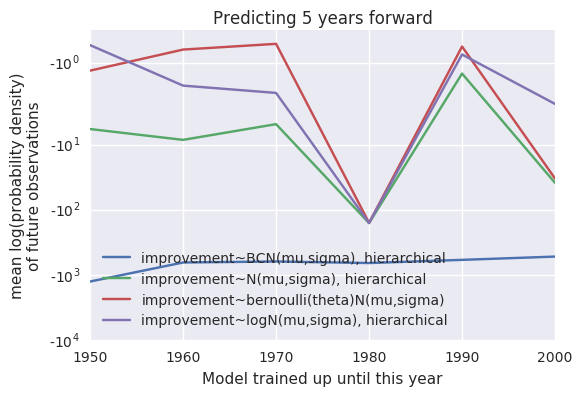

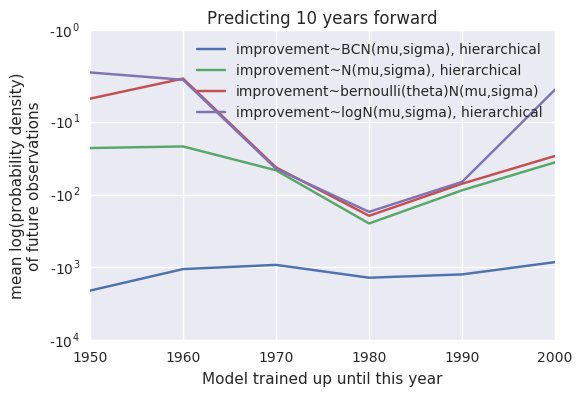

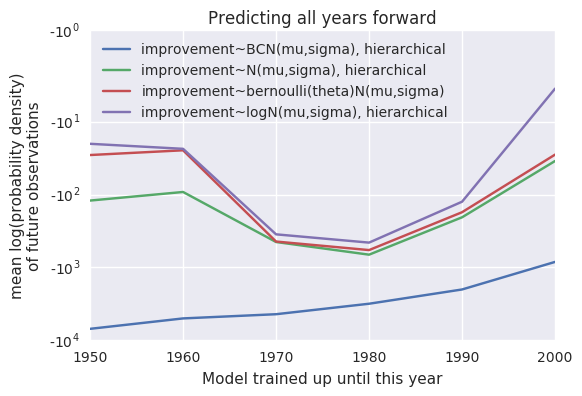

In [147]:
q = pd.Panel4D(technology_forecast_models_log_pd)#.drop(problem_techs,axis=1)
for i in arange(q.shape[2]):
    q.mean(axis=1).iloc[:,i].plot()
    title('Predicting '+str(q.major_axis[i])+' years forward')
    ylabel('mean log(probability density)\nof future observations')
    xlabel('Model trained up until this year')
    yscale('symlog')
    legend(loc='best')
    
# q = pd.Panel4D(technology_forecast_models_log_pd)
# for i in q.labels:
#     q[i].mean(axis=0).T.plot()
#     title(i)
#     ylabel('mean log(probability density)\nof future observations')
#     xlabel('Model trained up until this year')    

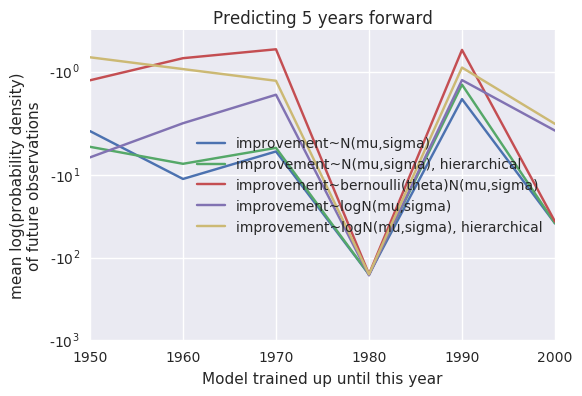

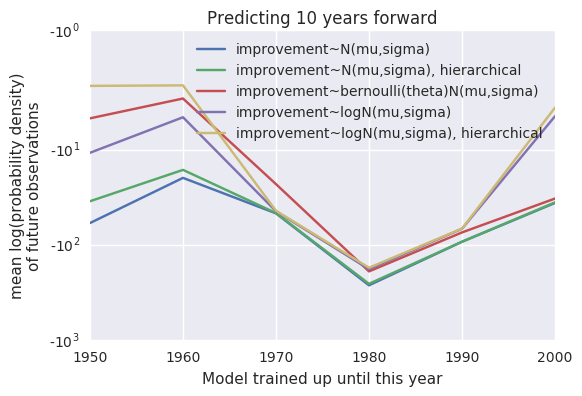

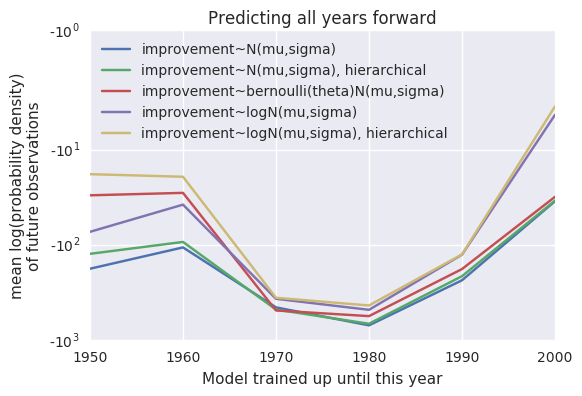

In [437]:
q = pd.Panel4D(technology_forecast_models_log_pd)#.drop(problem_techs,axis=1)
for i in arange(q.shape[2]):
    q.mean(axis=1).iloc[:,i].plot()
    title('Predicting '+str(q.major_axis[i])+' years forward')
    ylabel('mean log(probability density)\nof future observations')
    xlabel('Model trained up until this year')
    yscale('symlog')
    legend(loc='best')
    
# q = pd.Panel4D(technology_forecast_models_log_pd)
# for i in q.labels:
#     q[i].mean(axis=0).T.plot()
#     title(i)
#     ylabel('mean log(probability density)\nof future observations')
#     xlabel('Model trained up until this year')    

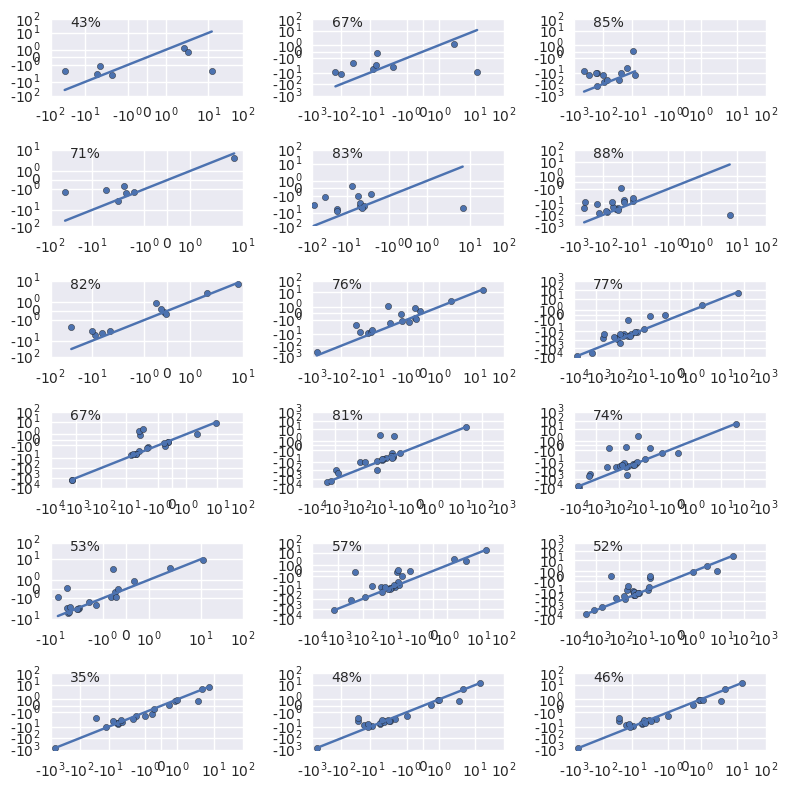

In [432]:
fig = figure(figsize=(8,8))
n_rows = len(training_years)
n_cols = len(horizons)
this_ax = 0
for training_year in training_years:
    for horizon in horizons:
        this_ax +=1
        ax = fig.add_subplot(n_rows, n_cols, this_ax)
        x = technology_forecast_models_log_pd['improvement~N(mu,sigma), hierarchical'].ix[:,:,training_year].T[horizon]
        y = technology_forecast_models_log_pd['improvement~bernoulli(theta)N(mu,sigma)'].ix[:,:,training_year].T[horizon]
        m = mean(y.dropna()>=x.dropna())*100
        ax.text(.1, .9, "%.0f%%"%m, transform=ax.transAxes)
        ax.scatter(x,y)
        xscale('symlog')
        yscale('symlog')
        plot(sort(x), sort(x))
#         xlim(min(x), max(x))
#         title("trained to %i, %s years forward"%(training_year, str(horizon)))
#         title("mean log(probability density)"
#               "\nof future observations, all technologies,"
#               "\ntrained to %i, %s years forward"%(training_year, str(horizon)))
#         xlabel("Normally Distributed Improvements")
#         ylabel("Lognormally Distributed Improvements")
fig.tight_layout()
# fig.suptitle('mean log(probability density) of future observations, all technologies')

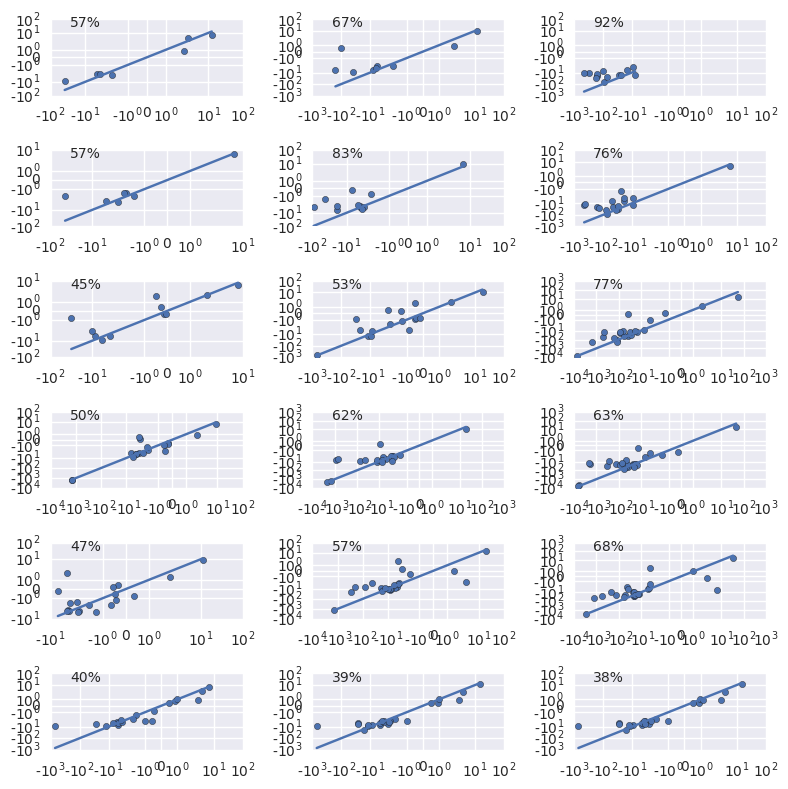

In [433]:
fig = figure(figsize=(8,8))
n_rows = len(training_years)
n_cols = len(horizons)
this_ax = 0
for training_year in training_years:
    for horizon in horizons:
        this_ax +=1
        ax = fig.add_subplot(n_rows, n_cols, this_ax)
        x = technology_forecast_models_log_pd['improvement~N(mu,sigma), hierarchical'].ix[:,:,training_year].T[horizon]
        y = technology_forecast_models_log_pd['improvement~logN(mu,sigma), hierarchical'].ix[:,:,training_year].T[horizon]
        m = mean(y.dropna()>=x.dropna())*100
        ax.text(.1, .9, "%.0f%%"%m, transform=ax.transAxes)
        ax.scatter(x,y)
        xscale('symlog')
        yscale('symlog')
        plot(sort(x), sort(x))
#         xlim(min(x), max(x))
#         title("trained to %i, %s years forward"%(training_year, str(horizon)))
#         title("mean log(probability density)"
#               "\nof future observations, all technologies,"
#               "\ntrained to %i, %s years forward"%(training_year, str(horizon)))
#         xlabel("Normally Distributed Improvements")
#         ylabel("Lognormally Distributed Improvements")
fig.tight_layout()
# fig.suptitle('mean log(probability density) of future observations, all technologies')

0.282051282051
0.205128205128


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


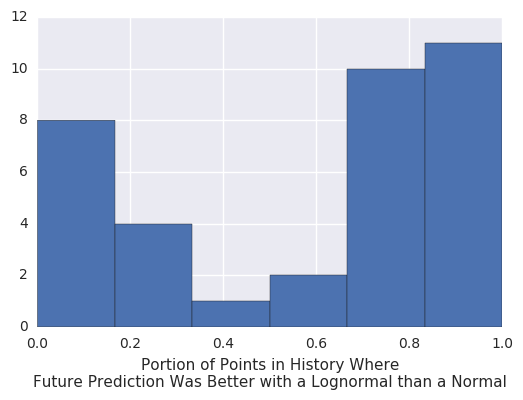

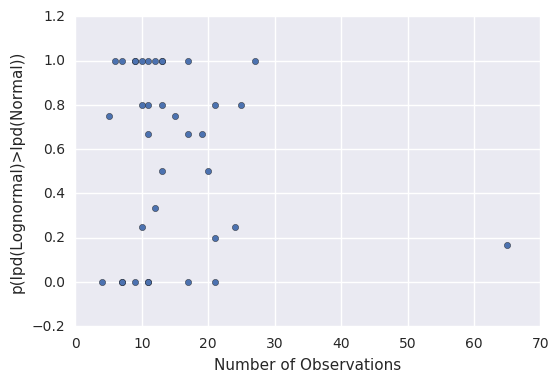

In [487]:
x = technology_forecast_models_log_pd['improvement~N(mu,sigma), hierarchical'].ix[:,'all']
y = technology_forecast_models_log_pd['improvement~logN(mu,sigma), hierarchical'].ix[:,'all']
s = pd.Series(index=x.columns)
for col in x.columns:
    s.ix[col] = mean(y[col].dropna()>=x[col].dropna())
s.hist(bins=x.shape[0])
xlabel("Portion of Points in History Where\nFuture Prediction Was Better with a Lognormal than a Normal")
print((s==1).mean())
print((s==0).mean())

figure()
scatter(empirical_time_series.notnull().sum(),s)
xlabel("Number of Observations")
ylabel("p(lpd(Lognormal)>lpd(Normal))")

0.282051282051
0.179487179487


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


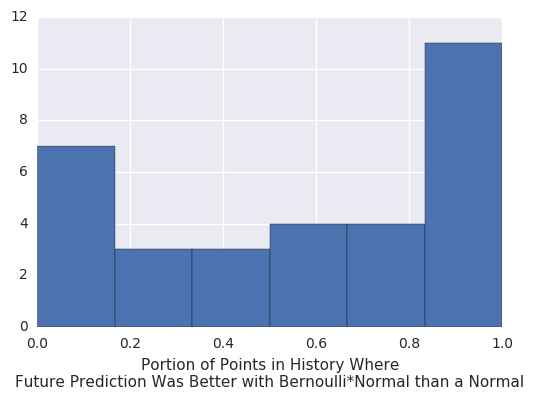

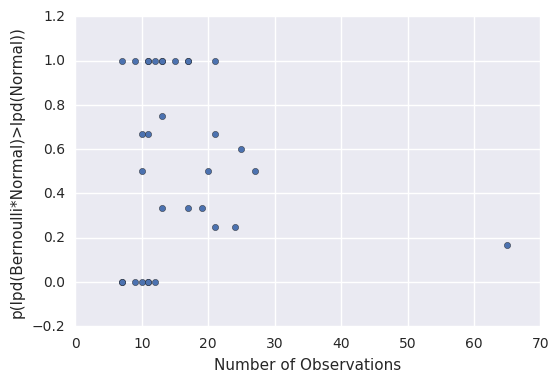

In [502]:
x = technology_forecast_models_log_pd['improvement~N(mu,sigma), hierarchical'].iloc[:,0]#.ix[:,'all']
y = technology_forecast_models_log_pd['improvement~bernoulli(theta)N(mu,sigma)'].iloc[:,0]#.ix[:,'all']
s = pd.Series(index=x.columns)
for col in x.columns:
    s.ix[col] = mean(y[col].dropna()>=x[col].dropna())
s.hist(bins=x.shape[0])
xlabel("Portion of Points in History Where\nFuture Prediction Was Better with Bernoulli*Normal than a Normal")
print((s==1).mean())
print((s==0).mean())

figure()
scatter(empirical_time_series.notnull().sum(),s)
xlabel("Number of Observations")
ylabel("p(lpd(Bernoulli*Normal)>lpd(Normal))")

0.307692307692
0.0769230769231


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


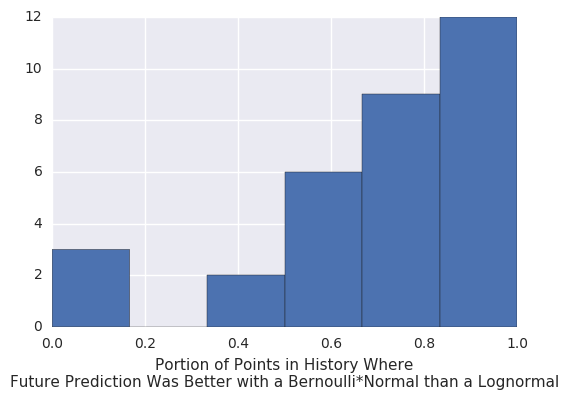

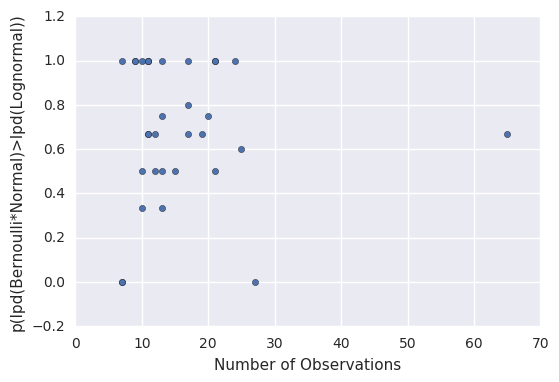

In [507]:
x = technology_forecast_models_log_pd['improvement~logN(mu,sigma), hierarchical'].iloc[:,1]#.ix[:,'all']
y = technology_forecast_models_log_pd['improvement~bernoulli(theta)N(mu,sigma)'].iloc[:,1]#.ix[:,'all']
s = pd.Series(index=x.columns)
for col in x.columns:
    s.ix[col] = mean(y[col].dropna()>=x[col].dropna())
s.hist(bins=x.shape[0])
xlabel("Portion of Points in History Where\nFuture Prediction Was Better with a Bernoulli*Normal than a Lognormal")
print((s==1).mean())
print((s==0).mean())

figure()
scatter(empirical_time_series.notnull().sum(),s)
xlabel("Number of Observations")
ylabel("p(lpd(Bernoulli*Normal)>lpd(Lognormal))")

Use Models to Predict Future Performance
===

In [194]:
target_tech_names = metadata.ix[(metadata['Type']=='Price')*(metadata['Source']=='Magee_et_al'), 'Name']
print("%i technologies"%target_tech_names.shape[0])

empirical_time_series = log(empirical_data[target_tech_names])

training_years = arange(1950,2010,10)
horizons = [5,10,'all']
min_data_points_to_include_time_series = 3

first_year = empirical_data.index[0]
price_time_series_from_each_time_period = {}

for training_year in training_years:
    print(training_year)

    start_ind = int(training_year-first_year)
    ### Select only those time series that have at least 3 data points from before the training year
    price_time_series_from_time_period = empirical_time_series.columns[empirical_time_series.iloc[:start_ind].notnull().sum(axis=0)>=min_data_points_to_include_time_series]
    price_time_series_from_each_time_period[training_year] = price_time_series_from_time_period
    
price_technology_forecast_models_Y_sim = {}
price_technology_forecast_models_log_pd = {}
price_technology_forecast_models_parameters = {}
price_technology_forecast_models_95CI = {}

27 technologies
1950
1960
1970
1980
1990
2000


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


In [195]:
for model_name in ['price~N(mu,sigma)', 
#                    'price~t(nu,mu,sigma)',
                   'price~N(mu,sigma), hierarchical', 
#                    'price~t(nu,mu,sigma), hierarchical'
                    ]:
    if 'improvement' in model_name:
        continue
    print(model_name)
    predict_with_model(model_name,
                       time_series=empirical_time_series,
                       training_years=training_years, horizons=horizons,
                       time_series_from_each_time_period=price_time_series_from_each_time_period,
                       technology_forecast_models_log_pd=price_technology_forecast_models_log_pd,
                       technology_forecast_models_parameters=price_technology_forecast_models_parameters,
                       technology_forecast_models_95CI=price_technology_forecast_models_95CI,
                       target_tech_names=target_tech_names)

price~N(mu,sigma)
1950
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]      0.52  1.1e-3   0.05   0.42   0.48   0.52   0.55   0.62   2215    1.0
mu[1]      0.17    0.01   0.43  -0.72  -0.08   0.18   0.42   1.03   1530    1.0
mu[2]      0.09  1.4e-3   0.07  -0.05   0.04   0.09   0.14   0.23   2649    1.0
mu[3]      0.04  7.9e-4   0.04  -0.04   0.01   0.04   0.06   0.12   2618    1.0
mu[4]      0.09  4.1e-4   0.02   0.05   0.08   0.09   0.11   0.14   3273    1.0
mu[5]      0.05  6.4e-5 4.0e-3   0.05   0.05   0.05   0.06   0.06   4000    1.0
sigma[0]   0.22  1.5e-3   0.06   0.14   0.18   0.21   0.25   0.38   1568    1.0
sigma[1]    1.1    0.01   0.41   0.59   0.82   1.01   1.29   2.14   1595    1.0
sigma[2]   0.49  1.1e-3   0.06   0.39   0.45   0.49   0.53   0.62   2664    1.0
sigma[3]    0.2  6.3e-4   0.03   0.15   0.18    0.2   0.22 

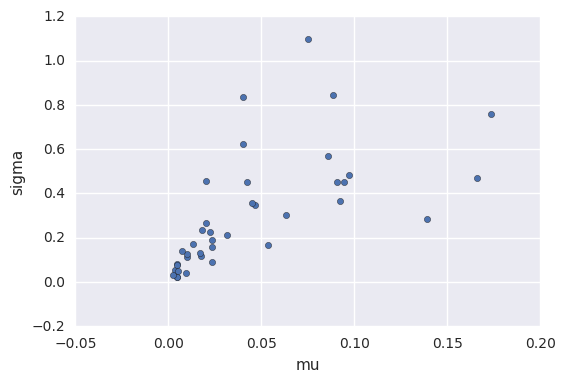

In [210]:
technology_models_fit_parameters['improvement~N(mu,sigma), hierarchical'].T.plot('mu', 'sigma', kind='scatter')

(0.0023848582843472598, 1.0)

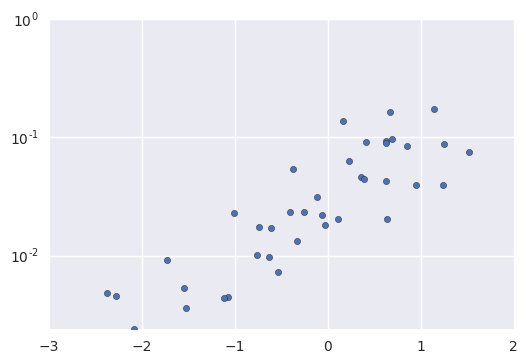

In [214]:
dist_mean = lambda df: norm(loc=df['mu'], scale=df['sigma']).mean()
dist_entropy = lambda df: norm(loc=df['mu'], scale=df['sigma']).entropy()
x = technology_models_fit_parameters['improvement~N(mu,sigma), hierarchical'].apply(dist_mean)
y = technology_models_fit_parameters['improvement~N(mu,sigma), hierarchical'].apply(dist_entropy)
scatter(y,x, label='Hierarchy')

# x = technology_models_fit_parameters['improvement~N(mu,sigma)'].apply(dist_mean)
# y = technology_models_fit_parameters['improvement~N(mu,sigma)'].apply(dist_entropy)
# scatter(x,y, label='No Hierarchy', color='red')
# xscale('log')
# xlim(xmin=x.min())
yscale('log')
ylim(ymin=x.min())

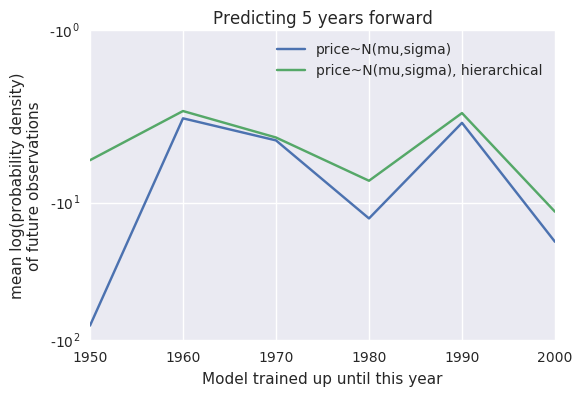

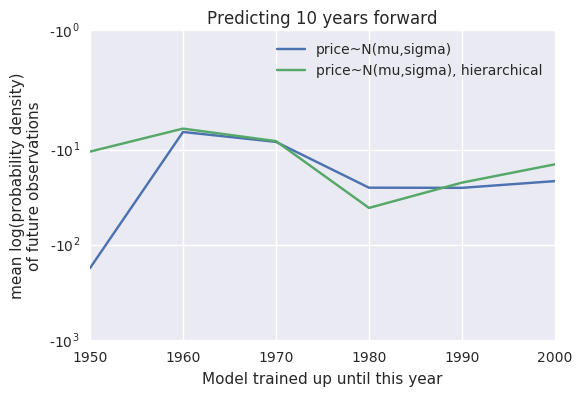

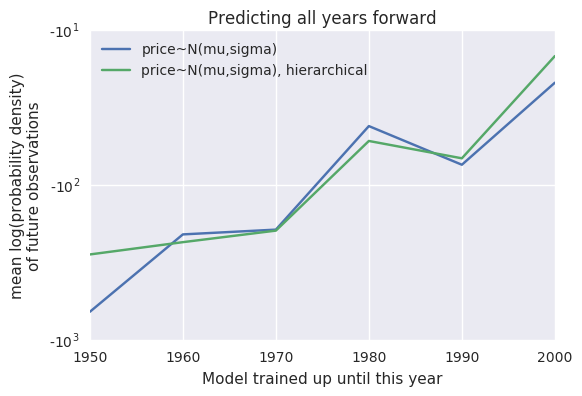

In [196]:
### Magee et al.
q = pd.Panel4D(price_technology_forecast_models_log_pd)#.drop(problem_techs,axis=1)
for i in arange(q.shape[2]):
    q.mean(axis=1).iloc[:,i].plot()
    title('Predicting '+str(q.major_axis[i])+' years forward')
    ylabel('mean log(probability density)\nof future observations')
    xlabel('Model trained up until this year')
    yscale('symlog')
    legend(loc='best')
    
# q = pd.Panel4D(technology_forecast_models_log_pd)
# for i in q.labels:
#     q[i].mean(axis=0).T.plot()
#     title(i)
#     ylabel('mean log(probability density)\nof future observations')
#     xlabel('Model trained up until this year')    

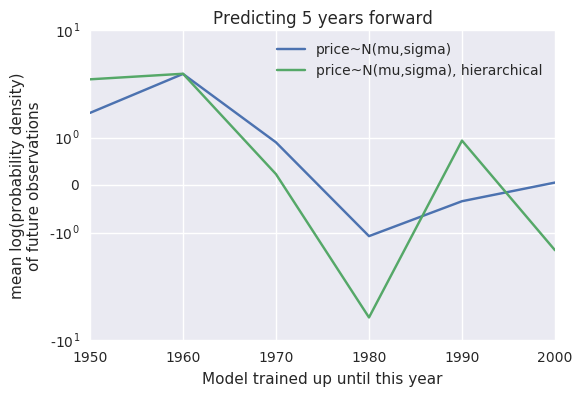

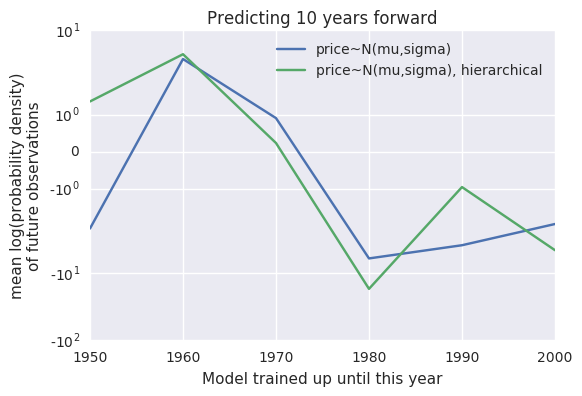

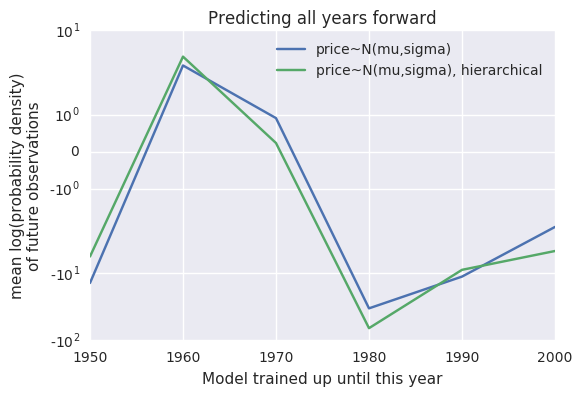

In [193]:
### Farmer and Lafond
q = pd.Panel4D(price_technology_forecast_models_log_pd)#.drop(problem_techs,axis=1)
for i in arange(q.shape[2]):
    q.mean(axis=1).iloc[:,i].plot()
    title('Predicting '+str(q.major_axis[i])+' years forward')
    ylabel('mean log(probability density)\nof future observations')
    xlabel('Model trained up until this year')
    yscale('symlog')
    legend(loc='best')
    
# q = pd.Panel4D(technology_forecast_models_log_pd)
# for i in q.labels:
#     q[i].mean(axis=0).T.plot()
#     title(i)
#     ylabel('mean log(probability density)\nof future observations')
#     xlabel('Model trained up until this year')    

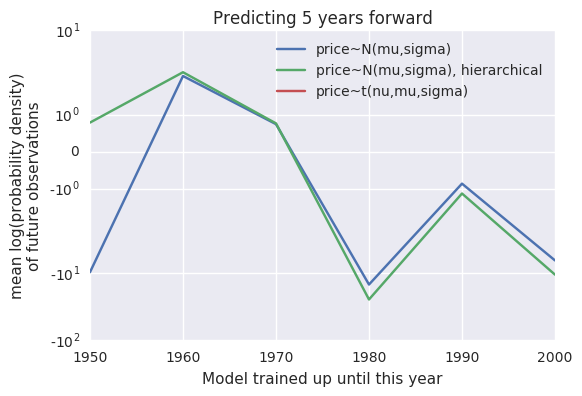

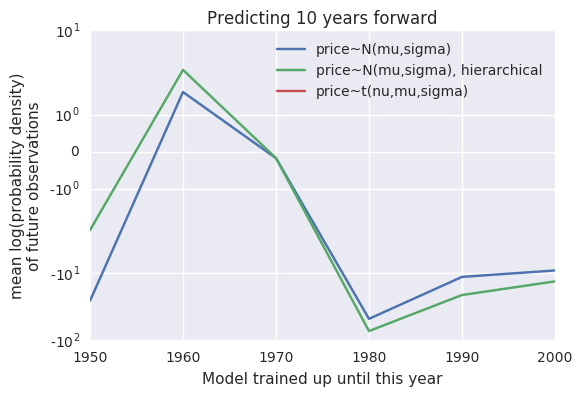

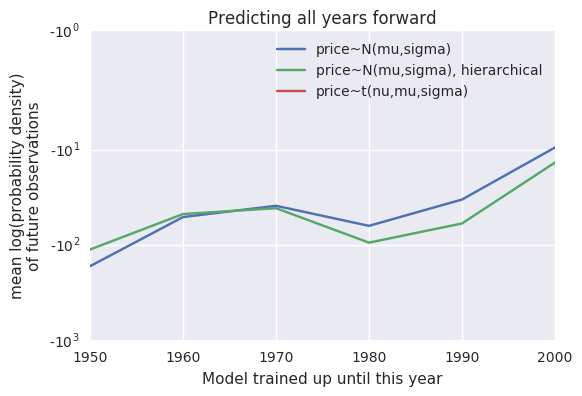

In [189]:
q = pd.Panel4D(price_technology_forecast_models_log_pd)#.drop(problem_techs,axis=1)
for i in arange(q.shape[2]):
    q.mean(axis=1).iloc[:,i].plot()
    title('Predicting '+str(q.major_axis[i])+' years forward')
    ylabel('mean log(probability density)\nof future observations')
    xlabel('Model trained up until this year')
    yscale('symlog')
    legend(loc='best')
    
# q = pd.Panel4D(technology_forecast_models_log_pd)
# for i in q.labels:
#     q[i].mean(axis=0).T.plot()
#     title(i)
#     ylabel('mean log(probability density)\nof future observations')
#     xlabel('Model trained up until this year')    

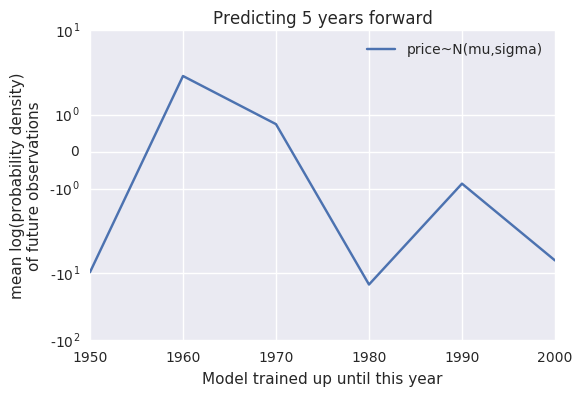

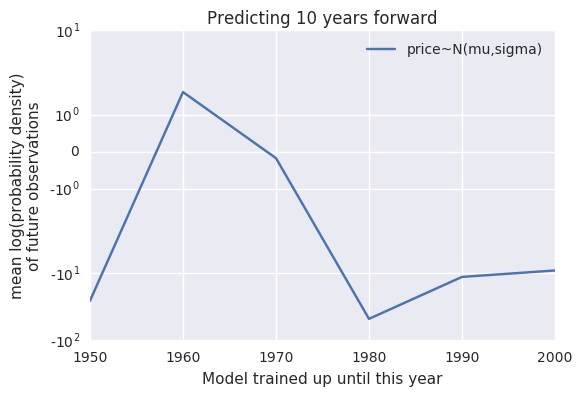

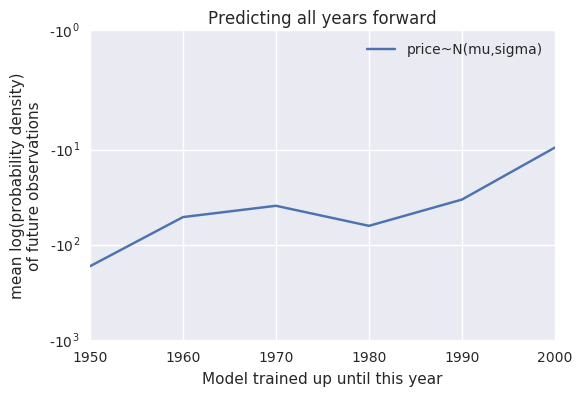

In [167]:
q = pd.Panel4D(price_technology_forecast_models_log_pd)#.drop(problem_techs,axis=1)
for i in arange(q.shape[2]):
    q.mean(axis=1).iloc[:,i].plot()
    title('Predicting '+str(q.major_axis[i])+' years forward')
    ylabel('mean log(probability density)\nof future observations')
    xlabel('Model trained up until this year')
    yscale('symlog')
    legend(loc='best')
    
# q = pd.Panel4D(technology_forecast_models_log_pd)
# for i in q.labels:
#     q[i].mean(axis=0).T.plot()
#     title(i)
#     ylabel('mean log(probability density)\nof future observations')
#     xlabel('Model trained up until this year')    

In [182]:
fl = metadata[(metadata['Source']=='Farmer_Lafond')*(metadata['Type']=='Price')]['Name'].values
mea = metadata[(metadata['Source']=='Magee_et_al')*(metadata['Type']=='Price')]['Name'].values

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


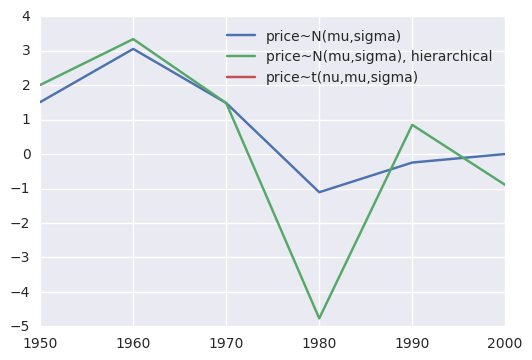

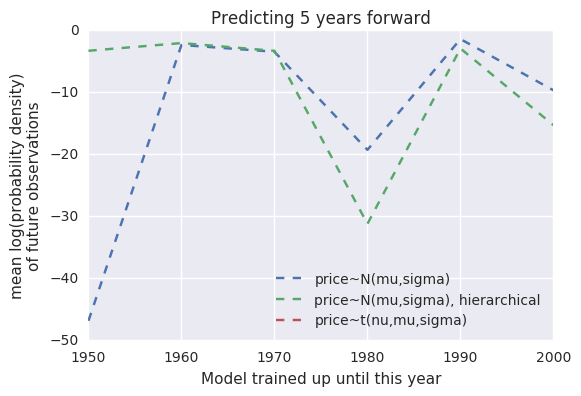

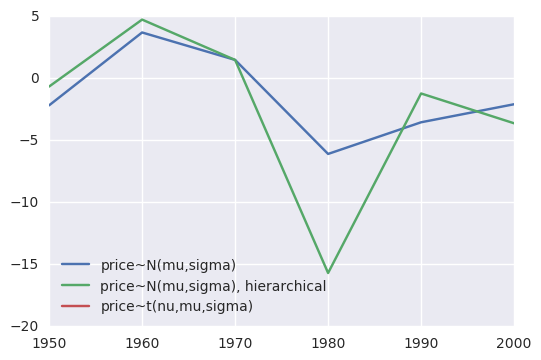

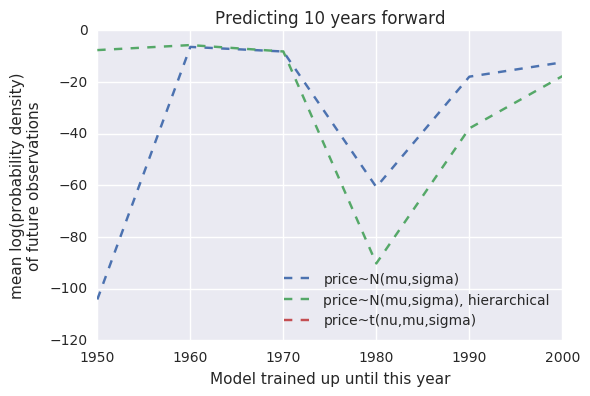

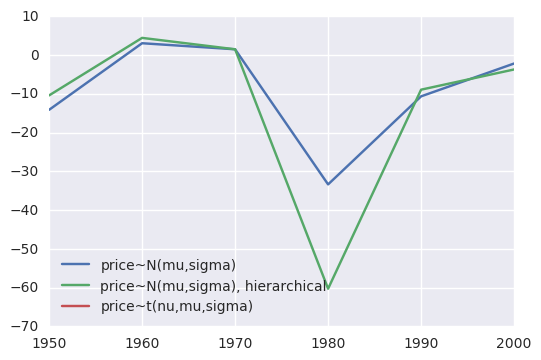

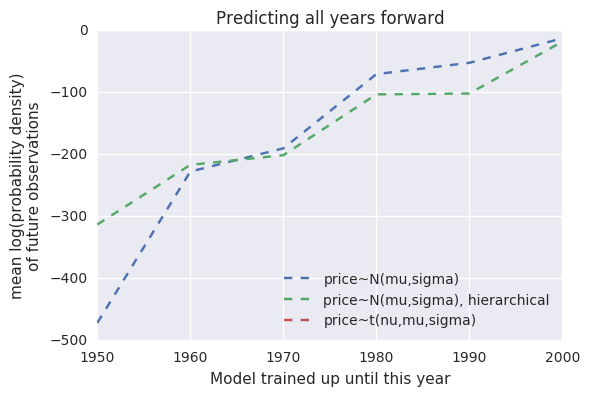

In [190]:
q = pd.Panel4D(price_technology_forecast_models_log_pd)#.drop(problem_techs,axis=1)
for i in arange(q.shape[2]):
    q.ix[:,fl].mean(axis=1).iloc[:,i].plot()
    q.ix[:,mea].mean(axis=1).iloc[:,i].plot(linestyle='--')
    title('Predicting '+str(q.major_axis[i])+' years forward')
    ylabel('mean log(probability density)\nof future observations')
    xlabel('Model trained up until this year')
#     yscale('symlog')
    legend(loc='best')
    
# q = pd.Panel4D(technology_forecast_models_log_pd)
# for i in q.labels:
#     q[i].mean(axis=0).T.plot()
#     title(i)
#     ylabel('mean log(probability density)\nof future observations')
#     xlabel('Model trained up until this year')    